In [21]:
import pandas as pd
import matplotlib.pyplot as plt            
import seaborn as sns         

# Load the CSV file into a DataFrame
featurelist_grouped = pd.read_csv(r"C:\Users\User\Documents\Forages\Pilot test\FL\Annotation_of_FL_FORAGES_PT_united_vs_library_iomicas_library_V3.1_final_MA_Methaneproduction.csv")

# Display the first few rows to confirm successful loading
#featurelist_grouped.head()

C:\Users\User\AppData\Local\Temp\ipykernel_15036\479143810.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  featurelist_grouped = pd.read_csv(r"C:\Users\User\Documents\Forages\Pilot test\FL\Annotation_of_FL_FORAGES_PT_united_vs_library_iomicas_library_V3.1_final_MA_Methaneproduction.csv")


In [23]:
# create group table

# Create a new DataFrame with column names as samples and the first row of featurelist_grouped as the group each belongs to
samples_table = pd.DataFrame(columns=featurelist_grouped.columns[1:], data=[featurelist_grouped.iloc[0, 1:].values])

# Display the first few rows of the samples tables
samples_table = samples_table.T

# Convert all columns to numeric, coercing errors to NaN
featurelist_grouped = featurelist_grouped.apply(pd.to_numeric, errors='coerce')




There are no negative values in the DataFrame.


In [42]:
import matplotlib.pyplot as plt
import pandas as pd

def scale_data(df, scaling_type):
    """
    Scale the data based on the specified scaling type and plot density before and after scaling.

    Parameters:
    df (pd.DataFrame): The input DataFrame to scale.
    scaling_type (str): The type of scaling to apply. Options are:
                        'none', 'mean_centering', 'auto', 'pareto', 'range'.                    

    Returns:
    pd.DataFrame: The scaled DataFrame.
    """
    df.drop(columns=['Feature'], inplace=True, errors='ignore')  # Drop the 'Feature' column if it exists
    df = df.astype(float)  # Convert all columns to float for scaling

    # Combine all columns into a single series for density plot
    combined_before = df.values.flatten()

    # Plot density before scaling
    plt.figure(figsize=(10, 6))
    plt.title("Density Before Scaling")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(True)
    pd.Series(combined_before).plot.kde(label="Before Scaling", linewidth=2)
    plt.legend()
    plt.xlim(-combined_before.mean()*5, combined_before.mean() * 5) 
    plt.show()

    # Apply scaling
    if scaling_type == 'none':
        scaled_df = df
    elif scaling_type == 'mean_centering':
        scaled_df = df - df.mean()
    elif scaling_type == 'auto':
        scaled_df = (df - df.mean()) / df.std()
    elif scaling_type == 'pareto':
        scaled_df = (df - df.mean()) / df.std()**0.5
    elif scaling_type == 'range':
        scaled_df = (df - df.mean()) / (df.max() - df.min())
    else:
        raise ValueError("Invalid scaling type. Choose from 'none', 'mean_centering', 'auto', 'pareto', 'range'.")

    # Combine all columns into a single series for density plot after scaling
    combined_after = scaled_df.values.flatten()

    # Plot density after scaling
    plt.figure(figsize=(10, 6))
    plt.title("Density After Scaling")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(True)
    pd.Series(combined_after).plot.kde(label="After Scaling", linewidth=2)
    plt.legend() 
    plt.show()

    return scaled_df

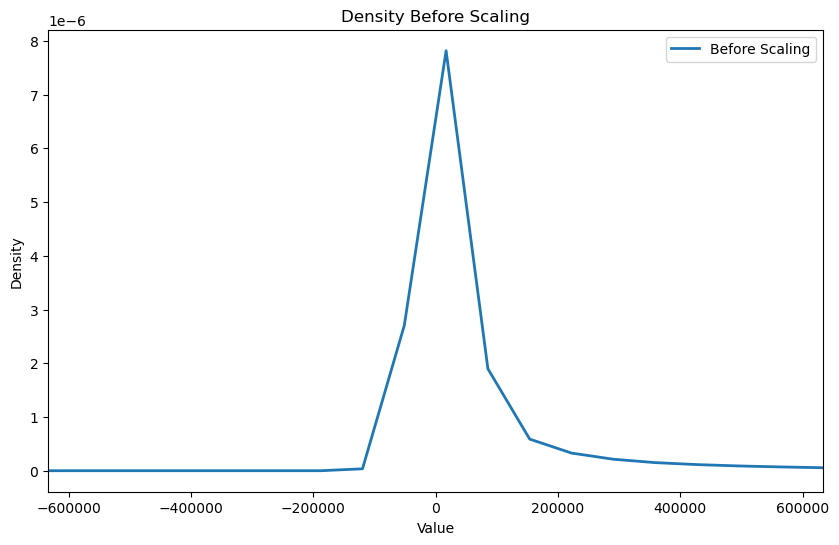

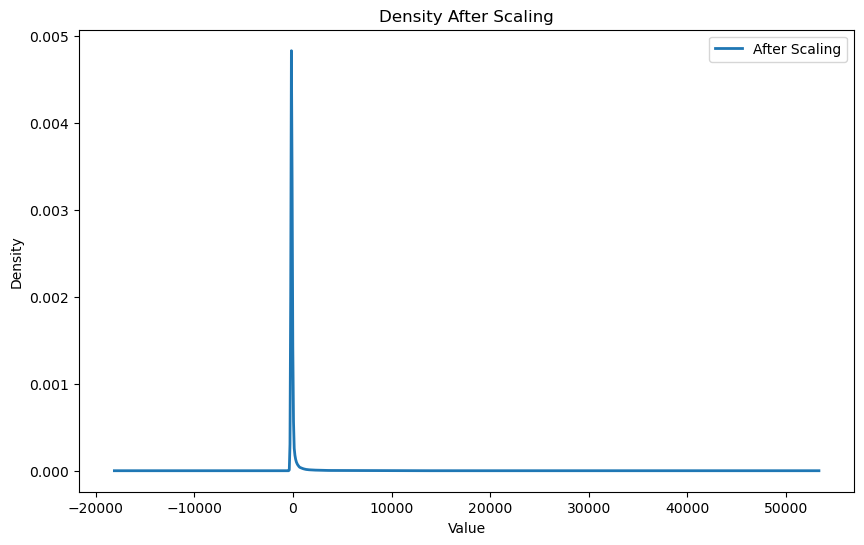

In [43]:
# Example usage:
scaling_type = 'pareto'  # Change this to 'none', 'mean_centering', 'auto', 'pareto', or 'range'
scaled_featurelist_grouped = scale_data(featurelist_grouped, scaling_type)

In [28]:
featurelist_grouped

,Extraction-blank_pos_4102025_002,Extraction-blank_pos_492025_003,Extraction-blank_pos_492025_004,FORAGES-PT_1010_pos_492025_017,FORAGES-PT_1010_pos_492025_018,FORAGES-PT_1010_pos_492025_019,FORAGES-PT_1013_pos_492025_014,FORAGES-PT_1013_pos_492025_015,FORAGES-PT_1013_pos_492025_016,FORAGES-PT_1015_pos_492025_036,...,FORAGES-PT_QC_pos_492025_006,FORAGES-PT_QC_pos_492025_007,FORAGES-PT_QC_pos_492025_008,FORAGES-PT_QC_pos_492025_009,FORAGES-PT_QC_pos_492025_010,FORAGES-PT_QC_pos_492025_035,FORAGES-PT_QC_pos_492025_066,Instrument-blank_pos_4102025_003,Instrument-blank_pos_492025_001,Instrument-blank_pos_492025_002
1,320043.5888,320832.8468,300690.8760,260490.94820,253616.72390,264277.36240,546902.04800,953516.103800,581784.56250,352051.006900,...,293528.520400,298825.118900,307121.519600,270314.743900,273360.130100,287084.627700,291656.096700,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,333.562328,0.00000,1509.599769,...,30042.250060,28168.928970,29097.726560,17664.704560,23104.590200,23942.409590,20718.553600,0.0000,0.0000,0.0000
3,316289.5256,356965.6838,350889.8635,762499.03260,758888.64770,745619.96330,627155.88910,604259.989800,629152.53960,708574.469700,...,748718.616400,704891.749600,705588.059900,716183.926100,705612.444500,725197.832300,706970.355500,0.0000,0.0000,0.0000
4,181984.1900,178610.7976,202010.6239,82205.44394,78647.45162,79274.21809,320971.79640,321386.575900,324222.68180,693916.187000,...,382156.589000,381536.021600,401527.464300,335901.369100,337786.302900,359681.362800,395174.959100,395201.1539,468523.0498,456453.5709
5,0.0000,0.0000,0.0000,89733.44575,85218.48953,91538.37626,25897.88074,5666.168051,22218.16554,15294.976840,...,120824.376500,117291.882300,122271.639400,109975.077800,114821.446900,123928.626800,101929.519500,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,...,6561.328877,6158.451238,6780.133110,4724.231930,3922.717301,6965.417691,6511.080630,0.0000,0.0000,0.0000
12112,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
12113,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,...,3255.766041,4408.246129,3441.445874,5240.454767,4488.270421,4181.735800,5459.290387,0.0000,0.0000,0.0000
12114,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
